# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [258]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import geopandas as gp
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [4]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 100
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [5]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [16]:
professions = {'Инкассатор': [], 'Автослесарь': [], 'Уборщик': [], 'Разработчик Python': [], 'Учитель китайского языка': []}
total = 0

for profession in professions.keys():
  params['text'] = profession
  data = requests.get(URL, params).json()

  print(f"Найдено профессий {profession}: {data['found']}. Собираем данные...")
  pages = data['pages']
  total += data['found']

  for page in range(pages):
    params['page'] = page
    data = requests.get(URL, params).json()
    sleep(0.5)

    for value in data['items']:
      value['profession'] = profession
      professions[profession].append(value)

  print(f"Записано: {len(professions[profession])}")

print("Данные успешно собраны!")

Найдено профессий Инкассатор: 49. Собираем данные...
Записано: 49
Найдено профессий Автослесарь: 594. Собираем данные...
Записано: 594
Найдено профессий Уборщик: 2826. Собираем данные...
Записано: 2000
Найдено профессий Разработчик Python: 2861. Собираем данные...
Записано: 2000
Найдено профессий Учитель китайского языка: 62. Собираем данные...
Записано: 62
Данные успешно собраны!


(1 балл) Посчитайте сколько всего найдено вакансий:

In [17]:
print(f"Всего найдено вакансий: {total}")

Всего найдено вакансий: 6392


(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [18]:
class Company:
    def __init__(self, name, id, x, y):
      self.name = name
      self.id = id
      self.lat = x
      self.lng = y

    def __repr__(self):
      return f"Company {self.name} with id = {self.id}"

    def __eq__(self, other):
      return self.id == other.id

    def __hash__(self):
      return hash(self.id)


(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [19]:
companies = set()

for profession in professions.keys():
  for vacancy in professions[profession]:
    try:
      company = Company(vacancy['employer']['name'], vacancy['employer']['id'], vacancy['address']['lat'], vacancy['address']['lng'])
      companies.add(company)
    except:
      continue

print(f"Компаний найдено: {len(companies)}")

Компаний найдено: 1932


(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [20]:
vacancies_with_coordinates = []
for profession in professions.keys():
  for vacancy in professions[profession]:
    if vacancy['address'] and vacancy['address']['lat']:
      vacancies_with_coordinates.append(vacancy)

print(f"Вакансий с координатами найдено: {len(vacancies_with_coordinates)}")

Вакансий с координатами найдено: 2959


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [26]:
mrr_vacancies = []
left = 37.3596241
right = 37.8476991
top = 55.914583
bottom = 55.57114

for vacancy in vacancies_with_coordinates:
  try:
    if (left <= vacancy['address']['lng'] <= right) and (bottom <= vacancy['address']['lat'] <= top):
      mrr_vacancies.append(vacancy)
  except:
    continue

print(f"Вакансий внутри МКАДа найдено: {len(mrr_vacancies)}")

Вакансий внутри МКАДа найдено: 2672


(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

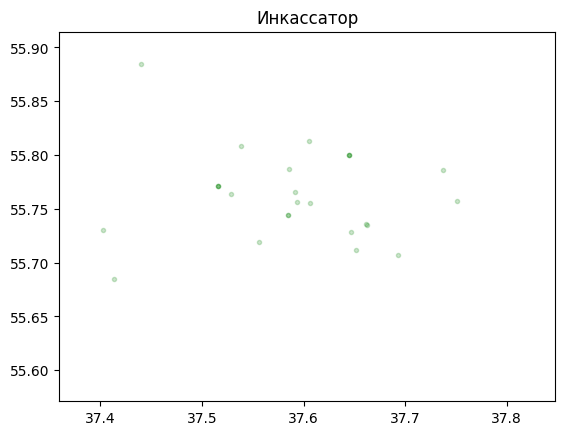

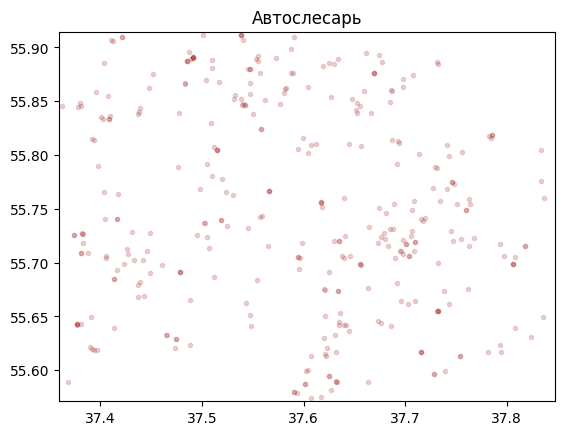

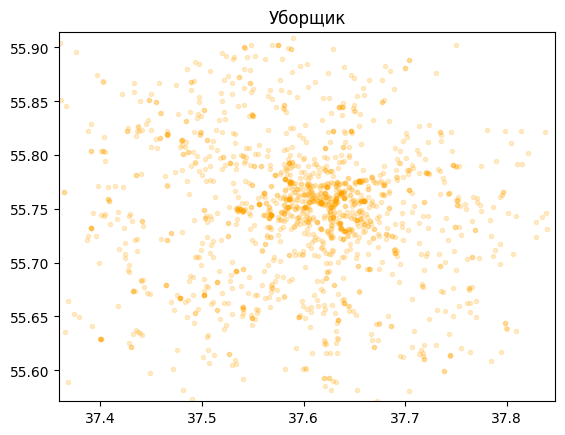

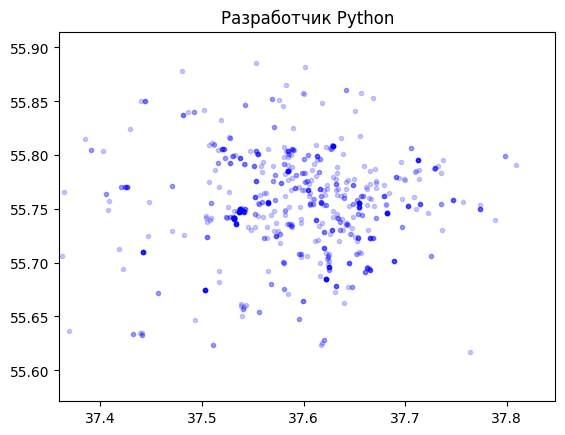

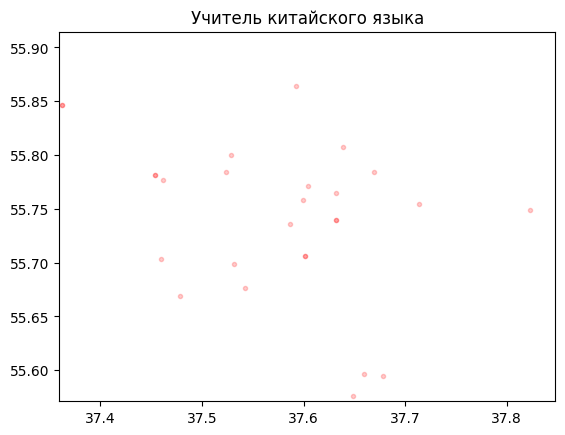

In [40]:
colors = {'Инкассатор': 'green', 'Автослесарь': 'brown', 'Уборщик': 'orange', 'Разработчик Python': 'blue', 'Учитель китайского языка': 'red'}

for profession in professions.keys():
  plt.axis((left, right, bottom, top))
  x = [vacancy['address']['lng'] for vacancy in mrr_vacancies if vacancy['profession'] == profession]
  y = [vacancy['address']['lat'] for vacancy in mrr_vacancies if vacancy['profession'] == profession]
  plt.plot(x, y, marker='.', linestyle='', alpha=0.2, color=colors[profession])
  plt.title(profession)
  plt.show()

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [24]:
!pip install mapclassify > /dev/null

In [42]:
data = {'job': [vacancy['name'] for vacancy in mrr_vacancies],
        'salary': [str(vacancy['salary']['from']) + vacancy['salary']['currency'] if vacancy['salary'] and str(vacancy['salary']['from']) != "None" else "no info" for vacancy in mrr_vacancies],
        'color': [colors[vacancy['profession']] for vacancy in mrr_vacancies]}

df = pd.DataFrame(data)

wkts = []
for vacancy in mrr_vacancies:
  wkts.append(f"Point ({vacancy['address']['lng']} {vacancy['address']['lat']})")
geom = gp.GeoSeries.from_wkt(wkts)
geom = geom.set_crs(4326)
geodf = gp.GeoDataFrame(data = df, geometry = geom)

geodf.explore(max_zoom = 13, min_zoom = 11, color = data['color'])

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

## **Выводы**

- Спрос на уборщиков больше в центре Москвы, в то время как вакансия автослесарь не имеет крупных скоплений и разбросана по всей Москве
- В районе Москва-сити сконцентрировано скопление IT вакансий, в которых не указана зарплата
- Зарплата уборщиков в среднем не зависит от геопозиции вакансии
- От преподавателей китайского языка зачастую требуют знания английского языка


## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [92]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 159MB/s]


Создадим DataFrame:

In [93]:
import pandas as pd

diamonds = pd.read_csv("/content/diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,NaN,Green,unknown,NaN,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [94]:
diamonds.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [95]:
quantity = diamonds.shape[0]
print(quantity)

219703


(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [96]:
min_price = min(diamonds['total_sales_price'])
max_price = max(diamonds['total_sales_price'])

min_price_diamonds = [i for i, cost in enumerate(diamonds['total_sales_price']) if cost == min_price]
max_price_diamonds = [i for i, cost in enumerate(diamonds['total_sales_price']) if cost == max_price]

print("Самые дешевые: ")
for index in min_price_diamonds:
  print(f"{index} - {min_price}$")

print("Самые дорогие: ")
for index in max_price_diamonds:
  print(f"{index} - {max_price}$")

Самые дешевые: 
0 - 200$
1 - 200$
2 - 200$
3 - 200$
4 - 200$
5 - 200$
6 - 200$
7 - 200$
8 - 200$
9 - 200$
10 - 200$
11 - 200$
12 - 200$
13 - 200$
14 - 200$
15 - 200$
16 - 200$
17 - 200$
18 - 200$
19 - 200$
20 - 200$
21 - 200$
22 - 200$
Самые дорогие: 
219702 - 1449881$


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [97]:
total_missing = 0

for column in diamonds.keys():
  counts = diamonds[column].value_counts()
  total_missing += (quantity - counts.sum()) + dict(counts.items()).get('unknown', 0)

print(total_missing)

1891168


(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [98]:
columns_with_missings = dict()

for column in diamonds.keys():
  counts = diamonds[column]
  missings = counts.isnull().sum() + dict(counts.value_counts()).get('unknown', 0)
  if missings > 0:
    columns_with_missings[column] = missings

for column in columns_with_missings.keys():
  print(column)

color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [99]:
fancy_or_fluor_columns = [column for column in columns_with_missings.keys() if column.startswith('fancy_color_') or column.startswith('fluor_')]

print(len(fancy_or_fluor_columns))

6


2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [100]:
for column in fancy_or_fluor_columns:
  print(f"informative cells in column {column}: {quantity - columns_with_missings[column]}")

informative cells in column fluor_color: 15726
informative cells in column fluor_intensity: 76084
informative cells in column fancy_color_dominant_color: 9164
informative cells in column fancy_color_secondary_color: 1062
informative cells in column fancy_color_overtone: 388
informative cells in column fancy_color_intensity: 9162


3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [101]:
diamonds = diamonds.drop(columns = fancy_or_fluor_columns)

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [102]:
culet_columns = [column for column in columns_with_missings.keys() if column.startswith('culet_')]

print(len(culet_columns))

for column in culet_columns:
  print(f"informative cells in column {column}: {quantity - columns_with_missings[column]}")

diamonds = diamonds.drop(columns = culet_columns)

2
informative cells in column culet_size: 133963
informative cells in column culet_condition: 15319


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [103]:
print(f"{diamonds['total_sales_price'].sum() / 1000} $")

1517721.991 $


Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [112]:
diamonds.iloc[::2]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [113]:
diamonds.iloc[::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [114]:
diamonds_table_with_categories = diamonds[["cut", "color", 'clarity', "cut_quality", 'lab', "symmetry", "polish", "eye_clean", "girdle_min", "girdle_max"]]
diamonds_table_with_categories

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [127]:
column = np.array(diamonds["total_sales_price"])
row = column.reshape(1,len(column))
print(row@column)

[158540672665477]


### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

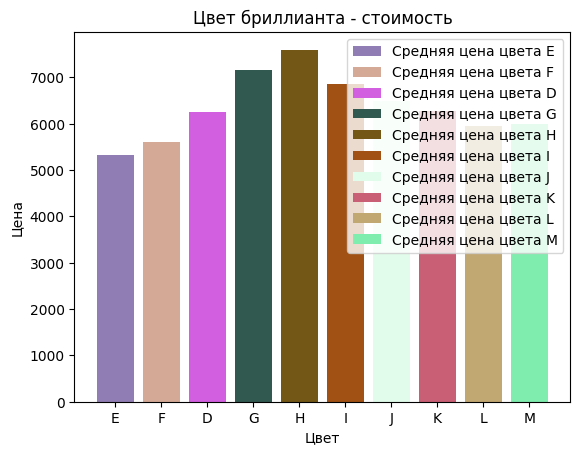

In [248]:
import random

labels = list(dict(diamonds['color'].value_counts()).keys())
labels.remove('unknown')
values = [diamonds[diamonds['color'] == color]['total_sales_price'].mean() for color in labels]
colors = [(random.randrange(0, 1000) / 1000, random.randrange(0, 1000) / 1000, random.randrange(0, 1000) / 1000) for i, value in enumerate(values)]


x = np.arange(len(labels))

fig, ax = plt.subplots()
bars = ax.bar(x, values, color=colors)

ax.set_ylabel('Цена')
ax.set_xlabel('Цвет')
ax.set_title('Цвет бриллианта - стоимость')

legend_labels = ["Средняя цена цвета " + str(category) for category, color in zip(labels, colors)]
ax.legend(bars, legend_labels)

ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    for i, rect in enumerate(rects):
        height = round(values[i])
        ax.annotate('',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars)

plt.show()

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

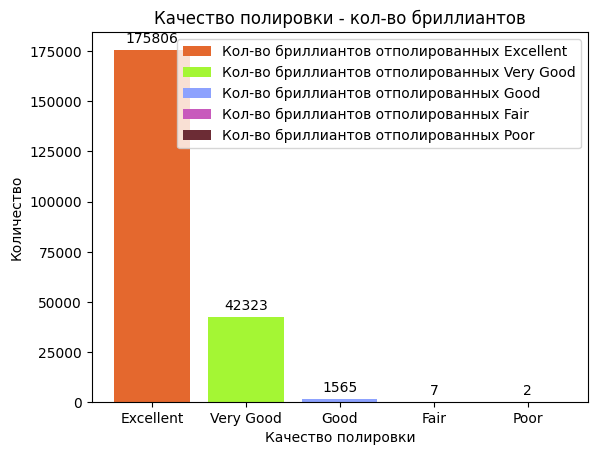

In [245]:
labels = list(dict(diamonds['polish'].value_counts()).keys())

values = [diamonds[diamonds['polish'] == polish]['Unnamed: 0'].size for polish in labels]
colors = [(random.randrange(0, 1000) / 1000, random.randrange(0, 1000) / 1000, random.randrange(0, 1000) / 1000) for i, value in enumerate(values)]


x = np.arange(len(labels))

fig, ax = plt.subplots()
bars = ax.bar(x, values, color=colors)

ax.set_ylabel('Количество')
ax.set_xlabel('Качество полировки')
ax.set_title('Качество полировки - кол-во бриллиантов')

legend_labels = ["Кол-во бриллиантов отполированных " + str(category) for category, color in zip(labels, colors)]
ax.legend(bars, legend_labels)

ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    for i, rect in enumerate(rects):
        height = round(values[i])
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars)

plt.show()

(2 балла) Постройте график `вес бриллианта - стоимость`:

In [236]:
x = []
y = []

for i, row in diamonds.iterrows():
  x.append(row["carat_weight"])
  y.append(row["total_sales_price"])

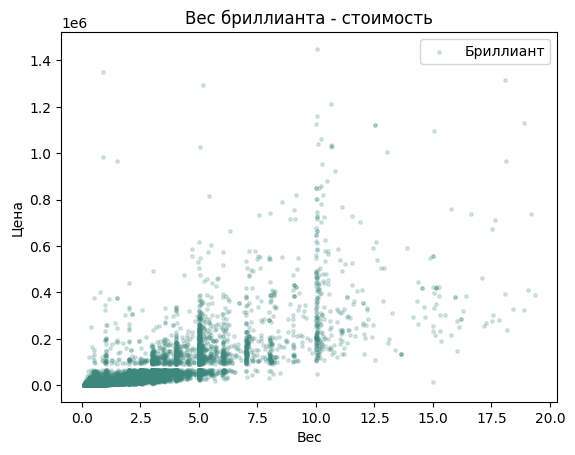

In [239]:
fig, ax = plt.subplots()
ax.scatter(x, y, color=(61 / 256, 136 / 256, 124 / 256), s=6, alpha=0.2)
ax.set_ylabel('Цена')
ax.set_xlabel('Вес')
ax.set_title('Вес бриллианта - стоимость')

ax.legend(['Бриллиант'])

plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

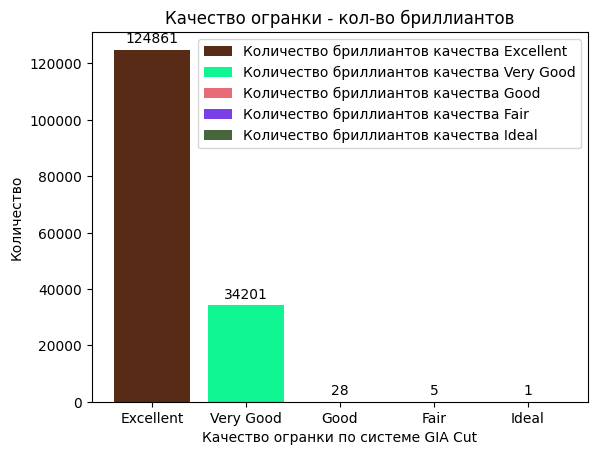

In [243]:
labels = list(dict(diamonds['cut_quality'].value_counts()).keys())
labels.remove('unknown')
values = [diamonds[diamonds['cut_quality'] == quality]['Unnamed: 0'].size for quality in labels]
colors = [(random.randrange(0, 1000) / 1000, random.randrange(0, 1000) / 1000, random.randrange(0, 1000) / 1000) for i, value in enumerate(values)]


x = np.arange(len(labels))

fig, ax = plt.subplots()
bars = ax.bar(x, values, color=colors)

ax.set_ylabel('Количество')
ax.set_xlabel('Качество огранки по системе GIA Cut')
ax.set_title('Качество огранки - кол-во бриллиантов')

legend_labels = ["Количество бриллиантов качества " + str(category) for category, color in zip(labels, colors)]
ax.legend(bars, legend_labels)

ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(bars)

plt.show()

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

## Выводы

- Средняя стоимость бриллианта имеет нормальное распределение относительно "желтоватости" его цвета
- Качество полировки этих бриллиантов довольно высоко
- Цена бриллианта зачастую имеет прямую зависимость от его веса
- Качество огранеи этих бриллиантов так же довольно высоко

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно:
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк:

In [249]:
data = diamonds[["meas_length","meas_width","meas_depth","total_sales_price"]]
data.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом:

In [250]:
data = data.sample(frac = 1)
data.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
56873,4.34,4.37,2.76,968
41576,4.17,4.20,2.70,886
41303,4.45,4.48,2.82,884
210150,8.20,8.25,5.12,26315
90172,4.67,4.71,2.96,1380
16961,4.33,3.05,2.10,688
7306,4.25,4.28,2.70,612
207656,7.78,6.35,4.54,22430
14477,4.31,4.33,2.62,684
158399,5.10,5.04,3.49,4300


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [252]:
data["summ"] = data["meas_length"] + data["meas_width"] + data["meas_depth"]

(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`:

In [254]:
ds = data[["summ", "total_sales_price"]]
ds

,summ,total_sales_price
56873,11.47,968
41576,11.07,886
41303,11.75,884
210150,21.57,26315
90172,12.34,1380
...,...,...
94144,12.75,1458
36178,11.79,844
24082,11.32,748
87587,13.52,1280


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [260]:
X_train, X_test, y_train, y_test = train_test_split(data, ds, test_size=2/8, random_state=42)

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

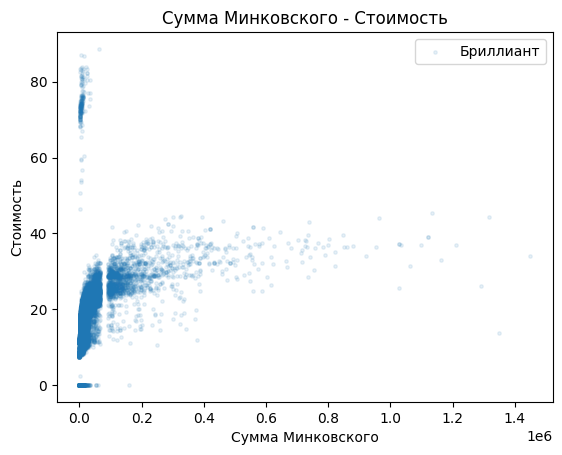

In [261]:
x = y_train['total_sales_price']
y = y_train['summ']


fig, ax1 = plt.subplots(nrows = 1, ncols = 1)

ax1.scatter(x, y, s=6, alpha=0.1)
ax1.set_title("Сумма Минковского - Стоимость")
ax1.legend(["Бриллиант"])
ax1.set_xlabel("Сумма Минковского")
ax1.set_ylabel("Стоимость")

fig.show()

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

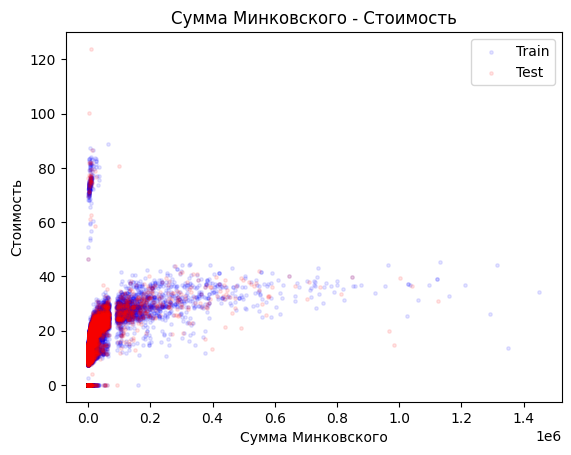

In [265]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1)

x = y_train['total_sales_price']
y = y_train['summ']

ax1.scatter(x, y, color='blue', s=6, alpha=0.1)
ax1.set_title("Сумма Минковского - Стоимость")
ax1.set_xlabel("Сумма Минковского")
ax1.set_ylabel("Стоимость")

x = y_test['total_sales_price']
y = y_test['summ']

ax1.scatter(x, y, s=6, color='red', alpha=0.1)
ax1.legend(["Train","Test"])

fig.show()

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [ ]:
# your code here

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [ ]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [ ]:
# your code here

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [ ]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [ ]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [ ]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)